In [ ]:
# For Colab
import sys
if 'google.colab' in sys.modules:
    !pip -q install geopandas 
    !git clone https://github.com/mggg/covid-analysis
    !mv covid-analysis/*.py covid-analysis/data .

In [2]:
%config InlineBackend.figure_formats = ['svg']
import os
import json
import numpy as np
import cvxpy as cp
import pandas as pd; pd.set_option('display.max_rows', 200)
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict
from state_data import load_state_data
from clinic_data import load_clinic_data

In [3]:
ed_inst_min_dorm_beds = 10  # filter out very minor institutions
staff_to_student_ratio = 0.5
percent_tested_per_day = 1/3
lab_capacity_per_day = 1000 # oof.

state_code = 'MA'
results_label = 'latest'

In [4]:
results_path = os.path.join('results', state_code)
os.makedirs(results_path, exist_ok=True)

In [5]:
state = load_state_data(state_code=state_code,
                        min_dorm_beds=10,
                        prefer_travel_time=False)

In [6]:
ed_inst_gdf = state['ed_inst']
outline_gdf = state['outline']
clinic_gdf = load_clinic_data().to_crs(ed_inst_gdf.crs)
clinic_gdf = clinic_gdf[clinic_gdf['state'] == 'Massachusetts'].reset_index()

## Spatiality of clinics and universities
In the plot below, <span style="color:blue">universities are blue circles</span> and <span style="color:red">clinics are red squares.</span>

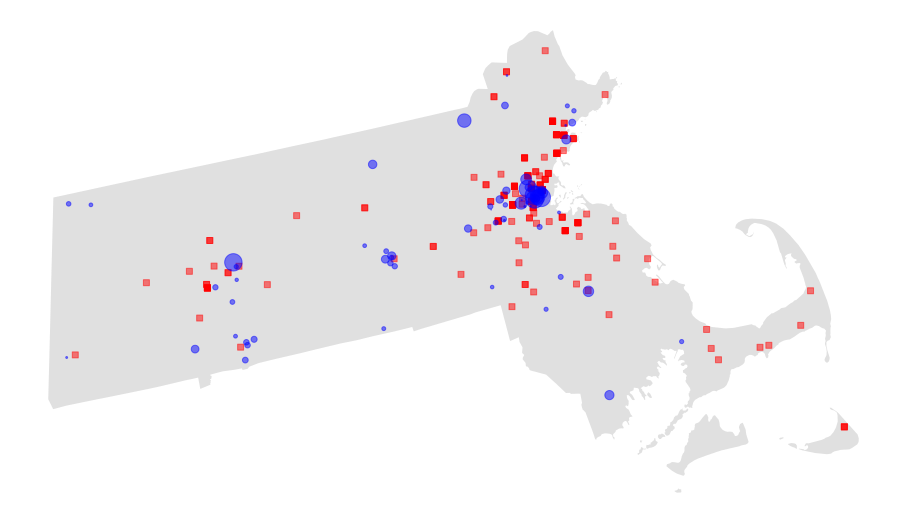

In [7]:
fig, ax = plt.subplots(figsize=(16, 16))
base = outline_gdf.plot(ax=ax, color='#e0e0e0')
clinic_gdf.plot(ax=base, marker='s', color='red', alpha=0.5)
ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                 markersize=0.01 * ed_inst_gdf['ENROLL'])
plt.axis('off')
plt.savefig(os.path.join(results_path, f'{state_code}_clinics.png'),
            bbox_inches='tight', dpi=600)
plt.show()

In [8]:
n_lab = len(clinic_gdf)
n_ed = len(ed_inst_gdf)

In [9]:
distances = np.zeros((n_lab, n_ed))
for clinic_idx, clinic_row in enumerate(clinic_gdf.itertuples()):
        for ed_idx, ed_row in enumerate(ed_inst_gdf.itertuples()):
            dist = clinic_row.geometry.distance(ed_row.geometry)
            distances[clinic_idx, ed_idx] = dist

In [10]:
# Supply and demand per day.
testing_demand = np.round(percent_tested_per_day * 
                          (1 + staff_to_student_ratio) *
                          ed_inst_gdf['ENROLL'].to_numpy())
lab_capacity = lab_capacity_per_day * np.ones(len(clinic_gdf))

In [11]:
print('demand:', testing_demand.sum())
print('capacity:', lab_capacity.sum())

demand: 219209.0
capacity: 239000.0


In [12]:
# Variables
assignment = cp.Variable((n_lab, n_ed))
constraints = [
    assignment >= 0, # Non-negativity.
    cp.sum(assignment, axis=1) <= lab_capacity, # Labs cannot be overutilized.
    cp.sum(assignment, axis=0) == testing_demand, # Demand must be satisfied.
]

# Objective: minimize average travel cost.
objective = cp.Minimize(cp.sum(cp.multiply(distances, assignment)))
prob = cp.Problem(objective, constraints=constraints)
prob.solve(verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.130e+10  -5.207e+10  +6e+10  6e-05  5e-09  1e+00  4e+06    ---    ---    1  1  - |  -  - 
 1  +9.889e+09  -5.316e+10  +7e+10  1e-03  6e-10  3e+06  4e+06  0.7800  1e+00   0  1  0 |  0  0
 2  +8.081e+09  -2.181e+10  +4e+10  3e-04  4e-10  2e+06  2e+06  0.7682  4e-01   0  1  1 |  0  0
 3  +6.898e+09  -7.730e+09  +2e+10  1e-04  2e-10  8e+05  1e+06  0.7412  4e-01   0  1  1 |  0  0
 4  +6.527e+09  -5.772e+09  +2e+10  1e-04  2e-10  7e+05  1e+06  0.2449  4e-01   0  1  1 |  0  0
 5  +6.083e+09  -3.221e+09  +1e+10  1e-04  2e-10  5e+05  8e+05  0.2980  2e-01   0  1  1 |  0  0
 6  +5.533e+09  -5.033e+08  +9e+09  1e-04  1e-10  3e+05  5e+05  0.4369  2e-01   0  1  1 |  0  0
 7  +5.127e+09  +7.710e+08  +6e+09  1e-04  9e-11  2e+05  4e+05  0.4192  4e-01   0  1  1 |  0  0
 8  +4.903e+09  +1.278e+09  +6e+09  1e-04  7e-

3489782832.305092

In [13]:
results = np.array(assignment.value)

In [14]:
def plot_assignments(results):
    fig, ax = plt.subplots(figsize=(16, 16))
    base = outline_gdf.plot(ax=ax, color='#e0e0e0')
    clinic_gdf.plot(ax=base, marker='s', color='red', alpha=0.5)
    ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                     markersize=0.01 * ed_inst_gdf['ENROLL'])
    
    for clinic_idx in range(n_lab):
        for ed_idx in range(n_ed):
            if results[clinic_idx, ed_idx] > 0:
                p_lab = clinic_gdf.iloc[clinic_idx].geometry
                p_ed = ed_inst_gdf.iloc[ed_idx].geometry
                ax.plot([p_lab.x, p_ed.x], [p_lab.y, p_ed.y],
                        color='black',
                        linewidth=0.001 * results[clinic_idx, ed_idx])
                
    plt.axis('off')

# Results
Our model's assignments are exported for use with [MGGG's Campus Coronavirus Response website](https://mggg.org/covid-flows/index.html).

In [19]:
plot_assignments(results)
plt.title('University-clinic assignments')
plt.savefig(os.path.join(results_path, f'{state_code}_{results_label}_clinic_assignments.png'),
            bbox_inches='tight', dpi=600)
plt.show()

In [16]:
clinic_lat_long_gdf = clinic_gdf.to_crs('EPSG:4326')  # WGS84
ed_inst_lat_long_gdf = ed_inst_gdf.to_crs('EPSG:4326')

In [17]:
def save_assignments(results, filename):
    assignments = []
    for clinic_idx, clinic_row in clinic_lat_long_gdf.iterrows():
        for ed_idx, ed_row in ed_inst_lat_long_gdf.iterrows():
            if results[clinic_idx, ed_idx] > 0:
                assignments.append({
                    'college': [ed_row.geometry.x, ed_row.geometry.y],
                    'hospital': [clinic_row.geometry.x, clinic_row.geometry.y],
                    'weight': int(results[clinic_idx, ed_idx])
                })
    with open(filename, 'w') as f:
        json.dump(assignments, f)

In [18]:
save_assignments(results,
                 os.path.join(results_path, f'{state_code}_{results_label}_clinic_results.json'))